In [17]:
import pandas as pd
import re
import pprint as pp

import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer  #  NLTK의 트윗 토크나이저(이모지 포함) 및 정규식 기반 토크나이저 불러오기
from nltk.corpus import stopwords  #  영어 불용어(stopwords) 리스트 불러오기
from textblob import TextBlob, Word  #  TextBlob을 이용한 감성 분석 및 단어 처리용 클래스 불러오기

nltk.download('punkt_tab')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_colwidth', None)   # 값 잘림 없음
pd.set_option('display.width', None) # 화면 폭 자동

%matplotlib inline

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
DF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets_covid1.csv', encoding='cp949')
DF = DF.replace('\n', ' ')
DF = DF.replace('-\n', ' ')
DF = DF.replace('&amp;', ' ')

print(len(DF))
DF.head()

119463


,index,id,text,hashtags,created_at,geo,like_count,quote_count,reply_count,retweet_count
0,6,1.420000e+18,Why South Korea has Better Response in COVID? Because they have a Better Government System and a Better Economic System.\n\nWhy our Country is not doing well? Because of our Current System of Governance which was bad and our Current Economic System which is also bad.,NaN,2021-07-31 22:33,NaN,3,0,0,0
1,7,1.420000e+18,Tokyo’s daily COVID cases hit record high during?Olympics https://t.co/yD16d1usex,NaN,2021-07-31 21:54,NaN,0,0,0,0
2,9,1.420000e+18,South Korea central bank holds rates as COVID-19 surge clouds tightening plans https://t.co/iaG17ARp7u\n#tlot,#tlot,2021-07-31 19:27,NaN,0,0,0,0
3,10,1.420000e+18,"S. Korea -\nSongjeong Beach in Busan, 450 kilometers southeast of Seoul, is relatively quiet on July 31, 2021, as South Korea has enhanced measures to curb COVID-19./Yonhap news https://t.co/wVwR5Sp8Kz",NaN,2021-07-31 18:56,NaN,0,0,0,0
4,11,1.420000e+18,"600,000 people died of Covid and just because Boris Johnson was worse doesn’t mean that Australia doesn’t exist. Or Vietnam. Or Japan. Or South Korea.\n\nMaybe at some point the hot takes are going a little too far, Shaun because on the face of it you look callous https://t.co/wNU6Cd9Xau",NaN,2021-07-31 17:35,NaN,3,0,2,0


In [10]:
# 특정 키워드 처리하기

DF['text'] = DF['text'].str.replace('South Korea', 'South_Korea')
DF['text'] = DF['text'].str.replace('south korea', 'south_korea')

DF['text'] = DF['text'].str.replace('North Korea', 'North_Korea')
DF['text'] = DF['text'].str.replace('north korea', 'north_korea')

DF['text'] = DF['text'].str.replace('human rights', 'human_rights')
DF['text'] = DF['text'].str.replace('Human Rights', 'Human_Rights')
DF['text'] = DF['text'].str.replace('Human rights', 'Human_rights')

DF['text'] = DF['text'].str.replace('United States', 'United_States')
DF['text'] = DF['text'].str.replace('U.S.', 'United_States')
DF['text'] = DF['text'].str.replace('Jeju island', 'Jeju_island')
DF['text'] = DF['text'].str.replace('Solomon Islands', 'Solomon_Islands')
DF['text'] = DF['text'].str.replace('Hong Kong', 'Hong_Kong')
DF['text'] = DF['text'].str.replace('New Zealand', 'New_Zealand')
DF['text'] = DF['text'].str.replace('Merete Lutz', 'Merete_Lutz')
DF['text'] = DF['text'].str.replace('Moon Jae-in', 'Moon_Jae-in')
DF['text'] = DF['text'].str.replace('Larry Hogan', 'Larry_Hogan')
DF['text'] = DF['text'].str.replace('Son Heung-min', 'Son_Heung-min')
DF['text'] = DF['text'].str.replace('Joe Biden', 'Joe_Biden')
DF['text'] = DF['text'].str.replace('New York Times', 'New_York_Times')

TWEET = DF['text']

In [11]:
## http, at 등 제거하기

def T_Tokenizer(TWEETER):  # 트윗 데이터 리스트를 입력 받아 전처리하는 함수 정의
    tweet_all = []  # 전체 전처리된 트윗을 저장할 리스트
    tweet_prep = []  # 각 트윗의 단어 단위 전처리 임시 저장 리스트

    tt = TweetTokenizer()  # 트위터 특화 토크나이저 객체 생성

    for tweet in TWEETER:  # 각 트윗에 대해 반복
        item = tt.tokenize(str(tweet))  # 트윗 텍스트를 토큰 단위로 분할

        for word in item:  # 각 토큰(단어)에 대해 반복
            h = re.compile("https://+.*|@+.*|http://+.*|#RT")  # http, https, @멘션, RT 해시태그 패턴 정의
            prep = re.sub(h, '', word)  # 해당 패턴이 있으면 빈 문자열로 치환
            tweet_prep.append(prep)  # 정제된 단어를 리스트에 추가

        tweet_prep = " ".join(tweet_prep)  # 정제된 단어들을 하나의 문자열로 결합
        tweet_all.append(tweet_prep)  # 전체 트윗 리스트에 추가
        tweet_prep = []  # 다음 트윗 처리를 위해 초기화

    return tweet_all  # 전처리된 전체 트윗 리스트 반환

TWEETT = T_Tokenizer(TWEET)

print(len(TWEETT))
print(TWEETT[0])

119463
Why South_Korea has Better Response in COVID ? Because they have a Better Government System and a Better Economic System . Why our Country is not doing well ? Because of our Current System of Governance which was bad and our Current Economic System which is also bad .


In [12]:
DF['no_http'] = TWEETT

In [13]:
## Exclude hashtag
HASHTAG = [" ".join([word for word in doc.split() if '#' in word]) for doc in TWEETT]
NOT_HASHTAG = [" ".join([word for word in doc.split() if not '#' in word]) for doc in TWEETT]

In [18]:
## Lemmatization 과 추가적인 전처리

POS = ['NN','NNP', 'JJ', 'FW'] # 일반명사, 고유명사, 형용사, 외래어 보존
                               # https://www.geeksforgeeks.org/python-part-of-speech-tagging-using-textblob/

stop_words = stopwords.words('english')  # NLTK의 기본 영어 불용어 리스트 불러오기
stops = ['case', 'cases', 'number', 'total', 'rate', 'rise', 'rises', 'week', 'daily', 'month', 'able', 'thing', 'yesterday', 'please',
         'year', 'today', 'many', 'much', 'minute', 'time', 'times', 'something', 'last', 'anything', 'day']  # 추가적인 불용어 수동 정의
stop_words.extend(stops)  # 두 리스트를 합침
stop_words = set(stop_words)  # 중복 제거를 위한 set 변환

def TB_lemmatization(texts):  # lemmatization 및 품사 기반 필터링 수행 함수 정의
    lemma_all = []  # 전체 lemmatization 결과 저장 리스트
    words = []  # 개별 문서의 결과 저장 리스트
    for doc in texts:  # 각 문서에 대해 반복
        doc = " ".join([Word(word).lemmatize("n") for word in doc.split()])  # 명사 기준 lemmatize 처리
        doc = TextBlob(doc)  # TextBlob 객체로 변환하여 품사 태깅 수행

        for word, tag in doc.tags:  # 각 단어와 품사에 대해 반복
            if(len(word) < 3 or word.lower() in stop_words):  # 3자 미만 또는 불용어는 제외
                continue
            if tag in POS:  # 지정한 품사만 추출
                words.append(word)

        words = " ".join(words).lower()  # 소문자로 통일 후 문자열로 결합
        lemma_all.append(words)  # 전체 결과에 추가
        words = []  # 다음 문서를 위해 초기화

    return lemma_all  # 전체 결과 반환

TWEETS_SORT = TB_lemmatization(NOT_HASHTAG)  # 전처리된 텍스트 데이터에 함수 적용

In [19]:
## 해시태그 텍스트 리스트를 전처리하는 함수 정의

def HTPrep(list):
    keyword_all = []  # 전체 전처리된 결과 저장 리스트
    keyword_prep = []  # 개별 전처리 결과 저장 리스트

    rex = RegexpTokenizer("[a-zA-Z]+")  # 해시태그 내에서 알파벳만 추출하는 정규표현식 토크나이저

    for tweet in list:  # 각 해시태그 트윗에 대해 반복
        item = rex.tokenize(tweet)  # 토크나이징 수행

        for word in item:  # 각 단어에 대해 반복
            if(word.lower() in stop_words):  # 소문자 기준 불용어 필터링
                continue
            if word:  # 비어있지 않은 단어만 처리
                h = re.compile("#")  # 해시 기호 제거용 패턴 정의
                prep = re.sub(h, '', word)  # # 제거
                keyword_prep.append(prep.lower())  # 소문자로 변환 후 리스트에 저장

        keyword_prep = " ".join(keyword_prep)  # 단어들을 문자열로 결합
        keyword_all.append(keyword_prep)  # 전체 리스트에 추가
        keyword_prep = []  # 다음 해시태그를 위해 초기화

    return keyword_all  # 전처리된 전체 해시태그 리스트 반환

HT_KEYWORD = HTPrep(HASHTAG)  # HASHTAG 리스트에 대해 전처리 함수 실행
HT_KEYWORD[10]  # 11번째 전처리된 해시태그 결과 출력

'popefrancis covid cbcpnews'

In [20]:
## 일반 텍스트와 해시태그를 결합한 최종 리스트

TWEET_MIX = []

for TN, HT in zip(TWEETS_SORT, HT_KEYWORD):  # 일반 텍스트와 해시태그를 동시에 순회
    Mix = "".join(TN + " " + HT)  # 일반 텍스트와 해시태그를 공백으로 구분하여 결합
    TWEET_MIX.append(Mix)  # 결합된 문장을 리스트에 저장

TWEET_MIX[0:5]  # 상위 5개의 결합 결과 출력

['south_korea better response covid government system better economic system country current system governance bad current economic system bad ',
 'tokyo covid record high ',
 'south_korea central bank hold covid surge cloud tightening plan tlot',
 'korea songjeong beach busan kilometer southeast seoul quiet july south_korea measure covid yonhap news ',
 'covid boris johnson mean australia vietnam japan south_korea hot take little shaun face callous ']

In [21]:
DF['hashtag'], DF['words'], DF['allwords'] = HASHTAG, TWEETS_SORT, TWEET_MIX

DF.head()

,index,id,text,hashtags,created_at,geo,like_count,quote_count,reply_count,retweet_count,no_http,hashtag,words,allwords
0,6,1.420000e+18,Why South_Korea has Better Response in COVID? Because they have a Better Government System and a Better Economic System.\n\nWhy our Country is not doing well? Because of our Current System of Governance which was bad and our Current Economic System which is also bad.,NaN,2021-07-31 22:33,NaN,3,0,0,0,Why South_Korea has Better Response in COVID ? Because they have a Better Government System and a Better Economic System . Why our Country is not doing well ? Because of our Current System of Governance which was bad and our Current Economic System which is also bad .,,south_korea better response covid government system better economic system country current system governance bad current economic system bad,south_korea better response covid government system better economic system country current system governance bad current economic system bad
1,7,1.420000e+18,Tokyo’s daily COVID cases hit record high during?Olympics https://t.co/yD16d1usex,NaN,2021-07-31 21:54,NaN,0,0,0,0,Tokyo ’ s daily COVID cases hit record high during ? Olympics,,tokyo covid record high,tokyo covid record high
2,9,1.420000e+18,South_Korea central bank holds rates as COVID-19 surge clouds tightening plans https://t.co/iaG17ARp7u\n#tlot,#tlot,2021-07-31 19:27,NaN,0,0,0,0,South_Korea central bank holds rates as COVID - 19 surge clouds tightening plans #tlot,#tlot,south_korea central bank hold covid surge cloud tightening plan,south_korea central bank hold covid surge cloud tightening plan tlot
3,10,1.420000e+18,"S. Korea -\nSongjeong Beach in Busan, 450 kilometers southeast of Seoul, is relatively quiet on July 31, 2021, as South_Korea has enhanced measures to curb COVID-19./Yonhap news https://t.co/wVwR5Sp8Kz",NaN,2021-07-31 18:56,NaN,0,0,0,0,"S . Korea - Songjeong Beach in Busan , 450 kilometers southeast of Seoul , is relatively quiet on July 31 , 2021 , as South_Korea has enhanced measures to curb COVID - 19 . / Yonhap news",,korea songjeong beach busan kilometer southeast seoul quiet july south_korea measure covid yonhap news,korea songjeong beach busan kilometer southeast seoul quiet july south_korea measure covid yonhap news
4,11,1.420000e+18,"600,000 people died of Covid and just because Boris Johnson was worse doesn’t mean that Australia doesn’t exist. Or Vietnam. Or Japan. Or South_Korea.\n\nMaybe at some point the hot takes are going a little too far, Shaun because on the face of it you look callous https://t.co/wNU6Cd9Xau",NaN,2021-07-31 17:35,NaN,3,0,2,0,"600,000 people died of Covid and just because Boris Johnson was worse doesn ’ t mean that Australia doesn ’ t exist . Or Vietnam . Or Japan . Or South_Korea . Maybe at some point the hot takes are going a little too far , Shaun because on the face of it you look callous",,covid boris johnson mean australia vietnam japan south_korea hot take little shaun face callous,covid boris johnson mean australia vietnam japan south_korea hot take little shaun face callous


In [22]:
## 트윗 리스트를 받아 특정 키워드를 제거하는 함수 정의

def T_Tokenizer(TWEETER):
    tweet_all = []  # 전체 전처리된 트윗 저장 리스트
    tweet_prep = []  # 개별 트윗 전처리 임시 저장 리스트

    tt = TweetTokenizer()  # 트위터 특화 토크나이저 객체 생성

    for tweet in TWEETER:  # 각 트윗에 대해 반복
        item = tt.tokenize(str(tweet))  # 텍스트를 토큰화

        for word in item:  # 각 단어에 대해 반복
            h = re.compile("covid|corona|coronavirus|south_korea|south_korean|southkorea|southkorean")  # 제거할 키워드 정의
            prep = re.sub(h, '', word)  # 키워드가 포함되면 제거
            tweet_prep.append(prep)  # 정제된 단어를 리스트에 추가

        tweet_prep = " ".join(tweet_prep)  # 정제된 단어들을 문자열로 결합
        tweet_all.append(tweet_prep)  # 전체 리스트에 추가
        tweet_prep = []  # 다음 트윗 처리를 위해 초기화

    return tweet_all  # 전처리된 전체 트윗 리스트 반환

TWEET_OUT = T_Tokenizer(DF['allwords'])  # 'allwords' 컬럼에서 키워드 제거 전처리 수행
len(TWEET_OUT)  # 전처리된 트윗 수 확인

print(TWEET_OUT[0])  # 첫 번째 트윗 결과 출력

 better response  government system better economic system country current system governance bad current economic system bad


In [23]:
DF['all_out'] = TWEET_OUT

In [25]:
DF.to_csv('/content/drive/MyDrive/Colab Notebooks/covidtest_22.csv', encoding = 'utf-8-sig',
           index_label = False, index = False)

print(len(DF))
DF.head()

119463


,index,id,text,hashtags,created_at,geo,like_count,quote_count,reply_count,retweet_count,no_http,hashtag,words,allwords,all_out
0,6,1.420000e+18,Why South_Korea has Better Response in COVID? Because they have a Better Government System and a Better Economic System.\n\nWhy our Country is not doing well? Because of our Current System of Governance which was bad and our Current Economic System which is also bad.,NaN,2021-07-31 22:33,NaN,3,0,0,0,Why South_Korea has Better Response in COVID ? Because they have a Better Government System and a Better Economic System . Why our Country is not doing well ? Because of our Current System of Governance which was bad and our Current Economic System which is also bad .,,south_korea better response covid government system better economic system country current system governance bad current economic system bad,south_korea better response covid government system better economic system country current system governance bad current economic system bad,better response government system better economic system country current system governance bad current economic system bad
1,7,1.420000e+18,Tokyo’s daily COVID cases hit record high during?Olympics https://t.co/yD16d1usex,NaN,2021-07-31 21:54,NaN,0,0,0,0,Tokyo ’ s daily COVID cases hit record high during ? Olympics,,tokyo covid record high,tokyo covid record high,tokyo record high
2,9,1.420000e+18,South_Korea central bank holds rates as COVID-19 surge clouds tightening plans https://t.co/iaG17ARp7u\n#tlot,#tlot,2021-07-31 19:27,NaN,0,0,0,0,South_Korea central bank holds rates as COVID - 19 surge clouds tightening plans #tlot,#tlot,south_korea central bank hold covid surge cloud tightening plan,south_korea central bank hold covid surge cloud tightening plan tlot,central bank hold surge cloud tightening plan tlot
3,10,1.420000e+18,"S. Korea -\nSongjeong Beach in Busan, 450 kilometers southeast of Seoul, is relatively quiet on July 31, 2021, as South_Korea has enhanced measures to curb COVID-19./Yonhap news https://t.co/wVwR5Sp8Kz",NaN,2021-07-31 18:56,NaN,0,0,0,0,"S . Korea - Songjeong Beach in Busan , 450 kilometers southeast of Seoul , is relatively quiet on July 31 , 2021 , as South_Korea has enhanced measures to curb COVID - 19 . / Yonhap news",,korea songjeong beach busan kilometer southeast seoul quiet july south_korea measure covid yonhap news,korea songjeong beach busan kilometer southeast seoul quiet july south_korea measure covid yonhap news,korea songjeong beach busan kilometer southeast seoul quiet july measure yonhap news
4,11,1.420000e+18,"600,000 people died of Covid and just because Boris Johnson was worse doesn’t mean that Australia doesn’t exist. Or Vietnam. Or Japan. Or South_Korea.\n\nMaybe at some point the hot takes are going a little too far, Shaun because on the face of it you look callous https://t.co/wNU6Cd9Xau",NaN,2021-07-31 17:35,NaN,3,0,2,0,"600,000 people died of Covid and just because Boris Johnson was worse doesn ’ t mean that Australia doesn ’ t exist . Or Vietnam . Or Japan . Or South_Korea . Maybe at some point the hot takes are going a little too far , Shaun because on the face of it you look callous",,covid boris johnson mean australia vietnam japan south_korea hot take little shaun face callous,covid boris johnson mean australia vietnam japan south_korea hot take little shaun face callous,boris johnson mean australia vietnam japan hot take little shaun face callous


In [26]:
DF1 = DF.drop_duplicates(subset=['no_http'], keep='last')  # 'no_http' 컬럼 기준으로 중복된 트윗 제거 (마지막 항목 유지)
DF1['yymm'] = DF1['created_at'].str[:7]  # 'created_at' 날짜에서 연-월(yyyy-mm) 형식만 추출하여 'yymm' 컬럼 생성

print(len(DF1))

88180


/tmp/ipython-input-2236635120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF1['yymm'] = DF1['created_at'].str[:7]  # 'created_at' 날짜에서 연-월(yyyy-mm) 형식만 추출하여 'yymm' 컬럼 생성


<Axes: xlabel='yymm'>

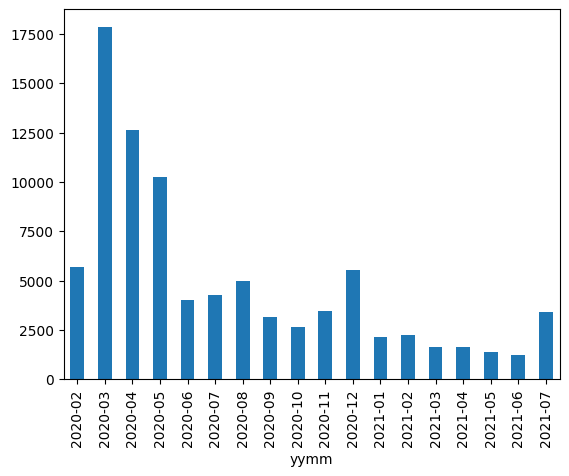

In [27]:
DF1['yymm'].value_counts().sort_index().plot.bar() # DF['Year'] 의 변수들을 개수만 카운트하여value_counts() 인덱싱한 뒤sort_index() 바그래프로 표현

In [28]:
## Word-count

vec = CountVectorizer().fit(TWEET_OUT)  # 전처리된 트윗 데이터를 학습하여 단어 사전 생성 (BoW 기반 벡터라이저)
bow = vec.transform(TWEET_OUT)  # 전처리된 텍스트를 DTM(문서-단어 행렬) 형태로 변환
sum_words = bow.sum(axis=0)  # 각 단어의 전체 등장 횟수를 열 단위로 합산
sum_words.shape[1]  # 전체 말뭉치에 등장한 고유 단어 수 출력


41392

In [29]:
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]  # 단어별로 해당 인덱스의 빈도 값을 추출하여 튜플로 저장
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)  # 빈도 기준으로 내림차순 정렬

for word, freq in words_freq[0:20]:  # 상위 20개 단어만 출력
    print(word, freq)  # 단어와 해당 TF-IDF 합계 값 출력

virus 28469
new 13985
death 10996
china 10633
country 10547
vaccine 8925
korea 8723
test 7779
news 6309
italy 6240
outbreak 6224
pandemic 6204
church 5985
japan 5918
world 5867
south 5428
report 5410
spread 4700
infection 4593
patient 4300
